In [1]:
!pip install stim
!pip install pymatching

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.7/663.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch
import stim
import pymatching
import os

In [3]:
def createcircuit(code_size, rounds, clifford_noise=0.0, reset_flip_prob=0.0, measure_flip_prob=0.0, round_data_noise=0.0):
    circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=rounds, distance=code_size,
            after_clifford_depolarization=clifford_noise,
            after_reset_flip_probability=reset_flip_prob,
            before_measure_flip_probability=measure_flip_prob,
            before_round_data_depolarization=round_data_noise)
    return circuit

def customreshape(samplelist, code_size):
    M = code_size+1
    images = []
    for vlist in samplelist:
        t = np.zeros((M,M), dtype=np.float32)
        t[0,1:-1:2] = vlist[0:int((code_size-1)/2)]
        k = 1
        l = 1
        st = int((code_size-1)/2)
        for i in range(code_size-1):
            t[l,k:k+code_size] = vlist[st:st+code_size]
            st = st+code_size
            if l%2 == 1:
                k = 0
            else:
                k = 1
            l += 1
        t[M-1,2:-1:2] = vlist[st:]
        padn = int((24-(code_size+1)*2)/2)
        images.append(np.pad(np.kron(t, np.ones((2,2))).astype(np.float32), pad_width=[(padn,padn),(padn,padn)], mode='constant'))
    return images

def sampledata(circuit, code_size, numsnaps, rounds):
    sampler = circuit.compile_detector_sampler()
    snapshots = []
    labels = []
    num_x_stabilizers = (int(code_size/2)+1)*(code_size-1)
    num_z_stabilizers = num_x_stabilizers
    num_stabilizers = num_x_stabilizers + num_z_stabilizers
    start = num_z_stabilizers + (rounds-2)*num_stabilizers
    res = numsnaps
    for i in range(2):
        snapshots_one_class = []
        labels_one_class = []
        while len(snapshots_one_class) < numsnaps/2:
            lsamples, obs = sampler.sample(shots=res, separate_observables=True)
            lsamples = lsamples[np.where(obs==i)[0]]
            obs = obs[np.where(obs==i)[0]]
            if lsamples.shape[0] < 1:
                continue
            lsamples = lsamples[:, start:start+num_stabilizers]
            non_empty_indices = (np.sum(lsamples, axis=1)!=0)
            reshapedsnapshots = customreshape(lsamples[non_empty_indices, :].tolist(), code_size)
            snapshots_one_class.extend(reshapedsnapshots)
            labels_one_class.extend(obs[non_empty_indices, :].astype(np.uint8))
            res = numsnaps - len(snapshots)
        snapshots.extend(snapshots_one_class)
        labels.extend(labels_one_class)
    X = np.stack(snapshots, axis=0)
    y =  np.stack(labels, axis=0)
    perm = np.random.permutation(X.shape[0])
    return [X[perm], y[perm]]

def sampledataforinference(circuit, code_size, numsnaps, rounds):
    sampler = circuit.compile_detector_sampler()
    pm = pymatching.Matching.from_detector_error_model(circuit.detector_error_model(decompose_errors=True))
    snapshots = []
    org_samples = []
    labels = []
    pm_preds = []
    num_x_stabilizers = (int(code_size/2)+1)*(code_size-1)
    num_z_stabilizers = num_x_stabilizers
    num_stabilizers = num_x_stabilizers + num_z_stabilizers
    start = num_z_stabilizers + (rounds-2)*num_stabilizers
    res = numsnaps
    while len(snapshots) < numsnaps:
        osamples, obs = sampler.sample(shots=res, separate_observables=True)
        lsamples = osamples[:, start:start+num_stabilizers]
        non_empty_indices = (np.sum(lsamples, axis=1)!=0)
        reshapedsnapshots = customreshape(lsamples[non_empty_indices, :].tolist(), code_size)
        snapshots.extend(reshapedsnapshots)
        org_samples.extend(osamples[non_empty_indices, :])
        labels.extend(obs[non_empty_indices, :].astype(np.uint8))
        res = numsnaps - len(snapshots)
    for samplearray in org_samples:
        pm_preds.extend(pm.decode(samplearray))
    X = np.stack(snapshots, axis=0)
    y =  np.stack(labels, axis=0)
    pm_preds_array = np.stack(pm_preds, axis=0)
    perm = np.random.permutation(X.shape[0])
    return [X[perm], y[perm], pm_preds_array[perm]]

In [4]:
class CustomTensorDataset(Dataset):
    def __init__(self, dataset, transform_list=None):
        [data_X, data_y] = dataset
        X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
        tensors = (X_tensor, y_tensor)
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transforms = transform_list

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transforms:
            x = self.transforms(x)
        y = self.tensors[1][index]
        return torch.unsqueeze(x, 0), y.float()

    def __len__(self):
        return self.tensors[0].size(0)

In [5]:
class Netlin1(nn.Module):
    def __init__(self, sizefirst):
        super(Netlin1, self).__init__()
        self.linlayers = nn.ModuleList()
        self.linlayers.append(nn.Linear(1*24*24,sizefirst))
        p1 = sizefirst
        p2 = int(p1/2)
        while p2 >= 128:
            self.linlayers.append(nn.Linear(p1,p2))
            p1 = p2
            p2 = int(p2/2)
        self.linlayers.append(nn.Linear(128,1))

    def forward(self, x):
        x = x.view(-1, 24*24)
        for i, l in enumerate(self.linlayers):
            if i == len(self.linlayers)-1:
                break
            x = torch.relu(self.linlayers[i](x))
            x = torch.relu(x)
        x = self.linlayers[-1](x)
        x = torch.sigmoid(x)
        return x

In [6]:
class Netlin2(nn.Module):
    def __init__(self, sizefirst):
        super(Netlin2, self).__init__()
        self.linlayers = nn.ModuleList()
        self.linlayers.append(nn.Linear(1*24*24,sizefirst))
        p1 = sizefirst
        p2 = int(p1/2)
        self.linlayers.append(nn.Linear(p1,128))
        self.linlayers.append(nn.Linear(128,1))

    def forward(self, x):
        x = x.view(-1, 24*24)
        for i, l in enumerate(self.linlayers):
            if i == len(self.linlayers)-1:
                break
            x = torch.relu(self.linlayers[i](x))
            x = torch.relu(x)
        x = self.linlayers[-1](x)
        x = torch.sigmoid(x)
        return x

In [8]:
class Netconv(nn.Module):
    def __init__(self, code_distance, num_outchannels, filter_size):
        super(Netconv, self).__init__()
        self.code_distance = code_distance
        self.num_outchannels = num_outchannels
        self.filter_size = filter_size
        oc = self.num_outchannels
        fz = self.filter_size
        self.conv1 = nn.Conv2d(1, oc, fz)
        self.conv2 = nn.Conv2d(oc, oc*2, fz)
        self.conv3 = nn.Conv2d(oc*2, oc*4, fz)
        if fz == 3:
            self.mpool = nn.MaxPool2d(6, 6)
            fv = oc*4*3*3
        elif fz == 5:
            self.mpool = nn.MaxPool2d(4, 4)
            fv = oc*4*3*3
        elif fz == 7:
            self.mpool = nn.MaxPool2d(2, 2)
            fv = oc*4*3*3
        self.fv = fv
        if self.code_distance == 5:
            self.fc1 = nn.Linear(fv, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, 1)
        elif self.code_distance == 7:
            self.fc1 = nn.Linear(fv, 1024)
            self.fc2 = nn.Linear(1024, 512)
            self.fc3 = nn.Linear(512, 128)
            self.fc4 = nn.Linear(128, 1)
        elif self.code_distance == 9:
            self.fc1 = nn.Linear(fv, 2048)
            self.fc2 = nn.Linear(2048, 1024)
            self.fc3 = nn.Linear(1024, 512)
            self.fc4 = nn.Linear(512, 128)
            self.fc5 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.mpool(x)
        x = x.view(-1, self.fv)
        if self.code_distance == 5:
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
        elif self.code_distance == 7:
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = self.fc4(x)
        elif self.code_distance == 9:
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = torch.relu(self.fc4(x))
            x = self.fc5(x)
        x = torch.sigmoid(x)
        return x

In [9]:
class Netconv5(nn.Module):
    def __init__(self):
        super(Netconv5, self).__init__()
        self.conv1 = nn.Conv2d(1, 24, 3)
        self.conv2 = nn.Conv2d(24, 24, 3)
        self.conv3 = nn.Conv2d(24, 16, 2)
        self.mpool = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(16*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.mpool(x)
        x = x.view(-1, 16*6*6)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [10]:
def trainmodel(model, code_distance, probs, training_instances, testloader, optimizer, criterion, numepochs, device, batchsize=32, valinterval=1):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    num = 0
    num_images = 0
    epochelapsed = 0
    ckt = createcircuit(code_distance, 2, round_data_noise=probs[0])
    #samplingobj = preparecktandsample(code_distance)
    #samplingobj.setnoisevectors(probs, round_data_noise=True)

    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    epochcounter = 0
    for epoch in range(numepochs):
        traintset = CustomTensorDataset(dataset=sampledata(ckt, code_distance, training_instances, 2))
        trainloader = torch.utils.data.DataLoader(traintset, batch_size=batchsize, shuffle=True, num_workers=0)
        #trainset = CustomTensorDataset(dataset = samplingobj.sampledata(training_instances))
        #trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True, num_workers=0)
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += ((outputs>0.5) == labels).sum().item()
            num_images += labels.size(0)
            print("\r images processed: {} and epoch {}".format(num_images, epoch+1), end='')

        epochcounter += 1
        if epochcounter == valinterval:
            train_loss /= (len(trainloader)*epochcounter)
            train_loss_history.append(train_loss)
            train_acc /= (len(trainloader.dataset)*epochcounter)
            train_acc_history.append(train_acc)

            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    val_acc += ((outputs > 0.5) == labels).sum().item()
            val_loss /= len(testloader)
            val_loss_history.append(val_loss)
            val_acc /= len(testloader.dataset)
            val_acc_history.append(val_acc)

            epochcounter = 0
            train_loss = 0.0
            train_acc = 0.0
            val_loss = 0.0
            val_acc = 0.0

    print("")
    return [train_loss_history, train_acc_history, val_loss_history, val_acc_history]

In [11]:
def sweepconvchannel(code_distance, directory="convelayer" ):
    os.makedirs(directory, exist_ok=True)
    fname1 = os.path.join(directory, "loss_accuracy_vs_outchannel_{}.csv".format(code_distance))
    fname2 = os.path.join(directory, "loss_accuracy_vs_outchannel_{}.png".format(code_distance))
    probs = [0.01]
    training_data_size = len(probs)*50000
    test_data_size = len(probs)*10000
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 32

    ckt = createcircuit(code_distance, 2, round_data_noise=probs[0])
    testset = CustomTensorDataset(dataset =  sampledata(ckt, code_distance, test_data_size, 2))
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

    criterion = nn.BCELoss()
    num_channels = [12, 24, 48]
    g1 = []
    g2 = []
    g3 = []
    g4 = []
    fout1 = open(fname1, 'w')
    fout1.write("NUM_CHANNELS,TRAIN-LOSS,VAL-LOSS,TRAIN-ACCURACY,VAL-ACCURACY\n")
    for nc in num_channels:
        net = Netconv(code_distance, nc, 5)
        net.to(device)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        [y1, y2, y3, y4] = trainmodel(net, code_distance, [0.01], \
                   training_data_size, testloader, \
                   optimizer, criterion, epochs, device, batchsize=32, valinterval=8)
        g1.append(y1[-1])
        g2.append(y2[-1])
        g3.append(y3[-1])
        g4.append(y4[-1])
        fout1.write("{},{},{},{},{}\n".format(nc, y1[-1], y3[-1], y2[-1], y4[-1]))
    fout1.close()
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].plot(num_channels, g1, label='train loss')
    axes[0].plot(num_channels, g3, label='val loss')
    axes[0].set_xlabel("Num Channels")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(num_channels, g2, label='train Accuracy')
    axes[1].plot(num_channels, g4, label='val Accuracy')
    axes[1].set_xlabel("Num Channels")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.savefig(fname2)
    plt.show()

 images processed: 1698920 and epoch 32
 images processed: 1698196 and epoch 32
 images processed: 1698604 and epoch 32


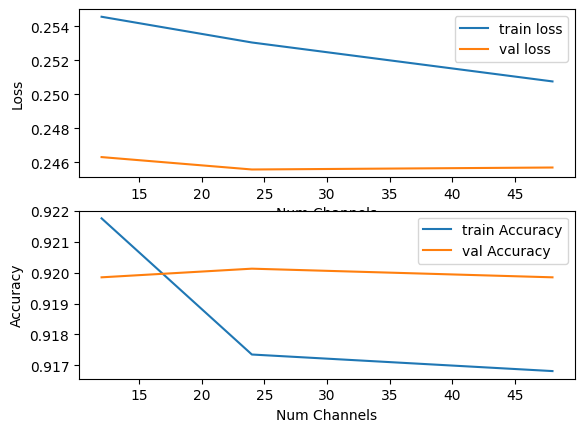

 images processed: 1876597 and epoch 32
 images processed: 1876497 and epoch 32
 images processed: 1874002 and epoch 32


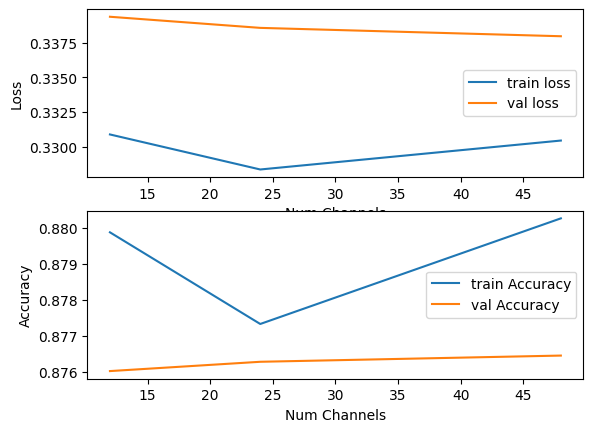

 images processed: 2322896 and epoch 32
 images processed: 2322591 and epoch 32
 images processed: 2322778 and epoch 32


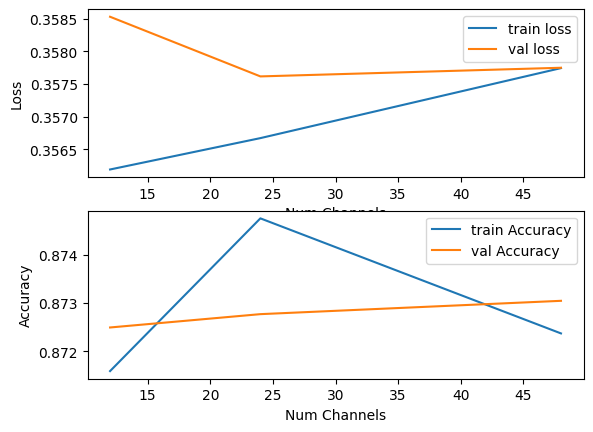

In [41]:
for codedist in [5, 7, 9]:
    sweepconvchannel(codedist)

In [12]:
def sweepconvfiltersize(code_distance, directory="convelayer" ):
    os.makedirs(directory, exist_ok=True)
    fname1 = os.path.join(directory, "loss_accuracy_vs_filtersizes_{}.csv".format(code_distance))
    fname2 = os.path.join(directory, "loss_accuracy_vs_filtersizes_{}.png".format(code_distance))
    probs = [0.01]
    training_data_size = len(probs)*50000
    test_data_size = len(probs)*10000
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 20

    ckt = createcircuit(code_distance, 2, round_data_noise=probs[0])
    testset = CustomTensorDataset(dataset =  sampledata(ckt, code_distance, test_data_size, 2))
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

    criterion = nn.BCELoss()
    filter_sizes = [3, 5, 7]
    g1 = []
    g2 = []
    g3 = []
    g4 = []
    fout1 = open(fname1, 'w')
    fout1.write("NUM_CHANNELS,TRAIN-LOSS,VAL-LOSS,TRAIN-ACCURACY,VAL-ACCURACY\n")
    for fz in filter_sizes:
        net = Netconv(code_distance, 24, fz)
        net.to(device)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        [y1, y2, y3, y4] = trainmodel(net, code_distance, [0.01], \
                   training_data_size, testloader, \
                   optimizer, criterion, epochs, device, batchsize=32, valinterval=2)
        g1.append(y1[-1])
        g2.append(y2[-1])
        g3.append(y3[-1])
        g4.append(y4[-1])
        fout1.write("{},{},{},{},{}\n".format(fz, y1[-1], y3[-1], y2[-1], y4[-1]))
    fout1.close()
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].plot(filter_sizes, g1, label='train loss')
    axes[0].plot(filter_sizes, g3, label='val loss')
    axes[0].set_xlabel("Filter sizes")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(filter_sizes, g2, label='train Accuracy')
    axes[1].plot(filter_sizes, g4, label='val Accuracy')
    axes[1].set_xlabel("Filter sizes")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.savefig(fname2)
    plt.show()

 images processed: 1063454 and epoch 20
 images processed: 1061264 and epoch 20
 images processed: 1062533 and epoch 20


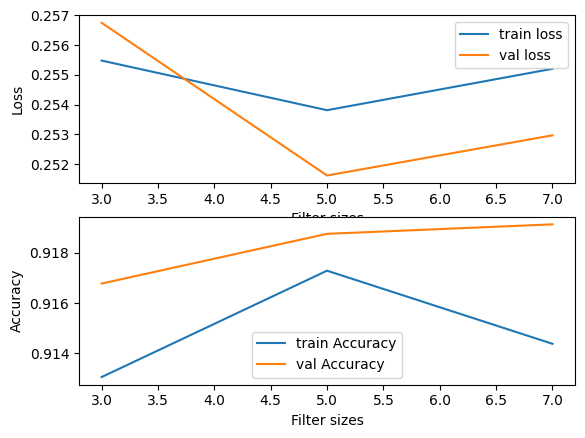

 images processed: 1172020 and epoch 20
 images processed: 1172589 and epoch 20
 images processed: 1172696 and epoch 20


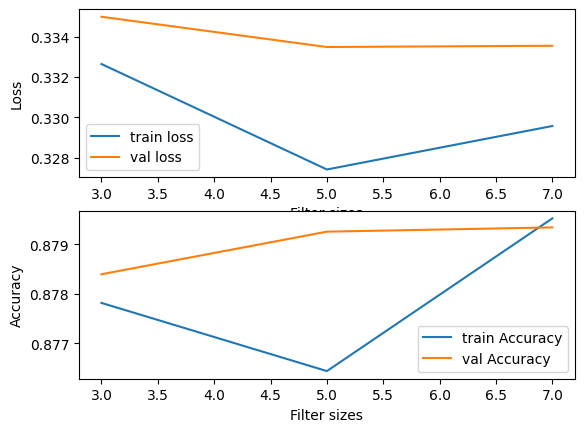

 images processed: 1450677 and epoch 20
 images processed: 1452475 and epoch 20
 images processed: 1451977 and epoch 20


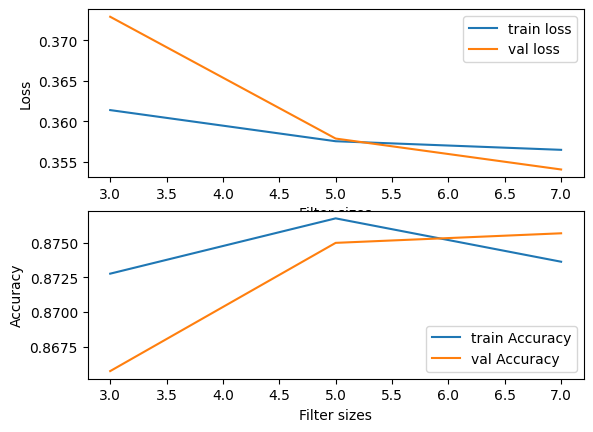

In [47]:
for codedist in [5, 7, 9]:
  sweepconvfiltersize(codedist, directory="convlayerfilter")

In [13]:
def sweepbatch(code_distance, directory="batchsize" ):
    os.makedirs(directory, exist_ok=True)
    fname1 = os.path.join(directory, "loss_accuracy_vs_batchsizes_{}.csv".format(code_distance))
    fname2 = os.path.join(directory, "loss_accuracy_vs_batchrsizes_{}.png".format(code_distance))
    probs = [0.011]
    training_data_size = len(probs)*50000
    test_data_size = len(probs)*10000
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 20


    ckt = createcircuit(code_distance, 2, round_data_noise=probs[0])
    testset = CustomTensorDataset(dataset =  sampledata(ckt, code_distance, test_data_size, 2))
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

    criterion = nn.BCELoss()
    batch_sizes = [16, 24, 32, 48]
    g1 = []
    g2 = []
    g3 = []
    g4 = []
    fout1 = open(fname1, 'w')
    fout1.write("BATCH_SIZES,TRAIN-LOSS,VAL-LOSS,TRAIN-ACCURACY,VAL-ACCURACY\n")
    for bs in batch_sizes:
        net = Netconv(code_distance, 24, 7)
        net.to(device)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        [y1, y2, y3, y4] = trainmodel(net, code_distance, [0.01], \
                   training_data_size, testloader, \
                   optimizer, criterion, epochs, device, batchsize=bs, valinterval=2)
        g1.append(y1[-1])
        g2.append(y2[-1])
        g3.append(y3[-1])
        g4.append(y4[-1])
        fout1.write("{},{},{},{},{}\n".format(bs, y1[-1], y3[-1], y2[-1], y4[-1]))
    fout1.close()
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].plot(batch_sizes, g1, label='train loss')
    axes[0].plot(batch_sizes, g3, label='val loss')
    axes[0].set_xlabel("Batch sizes")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(batch_sizes, g2, label='train Accuracy')
    axes[1].plot(batch_sizes, g4, label='val Accuracy')
    axes[1].set_xlabel("Batch sizes")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.savefig(fname2)
    plt.show()

 images processed: 1062574 and epoch 20
 images processed: 1061854 and epoch 20
 images processed: 1060602 and epoch 20
 images processed: 1062847 and epoch 20


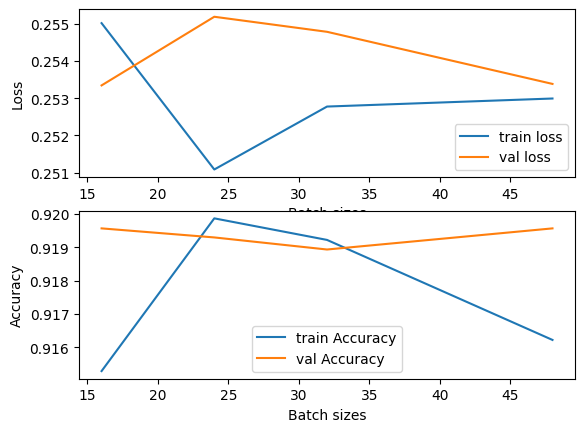

 images processed: 1172391 and epoch 20
 images processed: 1171204 and epoch 20
 images processed: 1171822 and epoch 20
 images processed: 1171478 and epoch 20


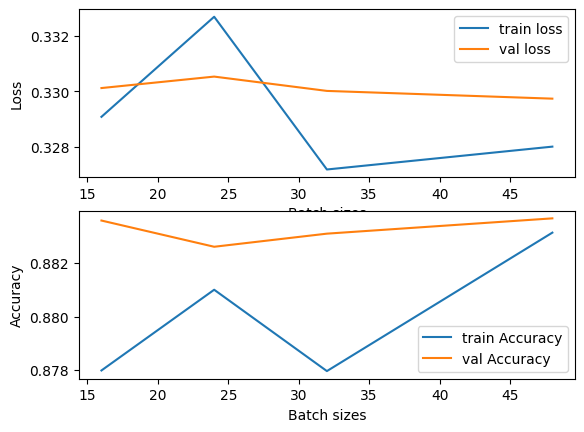

 images processed: 1451512 and epoch 20
 images processed: 1452213 and epoch 20
 images processed: 1452059 and epoch 20
 images processed: 1452094 and epoch 20


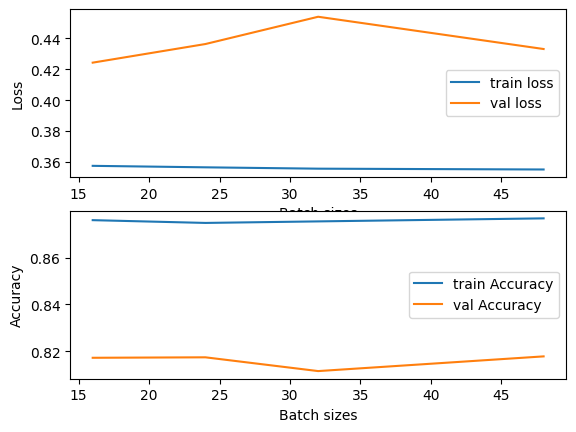

In [50]:
for codedist in [5, 7, 9]:
  sweepbatch(codedist)

In [14]:
def sweeplr(code_distance, directory="Learnrate" ):
    os.makedirs(directory, exist_ok=True)
    fname1 = os.path.join(directory, "loss_accuracy_vs_lr_{}.csv".format(code_distance))
    fname2 = os.path.join(directory, "loss_accuracy_vs_lr_{}.png".format(code_distance))
    probs = [0.01]
    training_data_size = len(probs)*50000
    test_data_size = len(probs)*1000
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 20


    ckt = createcircuit(code_distance, 2, round_data_noise=probs[0])
    testset = CustomTensorDataset(dataset =  sampledata(ckt, code_distance, test_data_size, 2))
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

    criterion = nn.BCELoss()
    learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
    g1 = []
    g2 = []
    g3 = []
    g4 = []
    fout1 = open(fname1, 'w')
    fout1.write("LR,TRAIN-LOSS,VAL-LOSS,TRAIN-ACCURACY,VAL-ACCURACY\n")
    for lrv in learning_rates:
        net = Netconv(code_distance, 24, 7)
        net.to(device)
        optimizer = optim.Adam(net.parameters(), lr=lrv)
        [y1, y2, y3, y4] = trainmodel(net, code_distance, [0.01], \
                   training_data_size, testloader, \
                   optimizer, criterion, epochs, device, batchsize=48, valinterval=2)

        g1.append(y1[-1])
        g2.append(y2[-1])
        g3.append(y3[-1])
        g4.append(y4[-1])
        fout1.write("{},{},{},{},{}\n".format(lrv, y1[-1], y3[-1], y2[-1], y4[-1]))
    fout1.close()
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].plot(learning_rates, g1, label='train loss')
    axes[0].plot(learning_rates, g3, label='val loss')
    axes[0].set_xlabel("Learning Rate")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(learning_rates, g2, label='train Accuracy')
    axes[1].plot(learning_rates, g4, label='val Accuracy')
    axes[1].set_xlabel("Learning Rate")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.savefig(fname2)
    plt.show()

 images processed: 1061747 and epoch 20
 images processed: 1061388 and epoch 20
 images processed: 1061347 and epoch 20
 images processed: 1061161 and epoch 20
 images processed: 1060998 and epoch 20


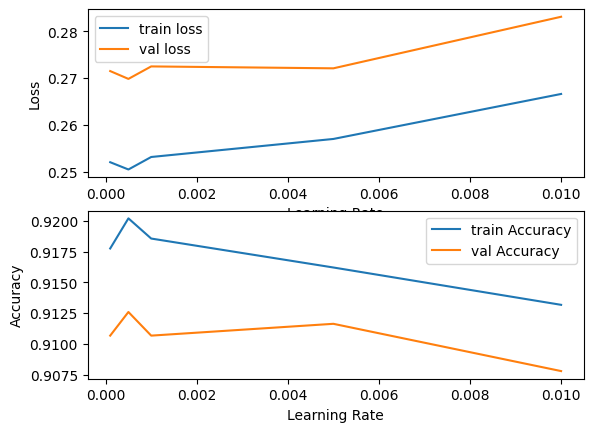

 images processed: 1172277 and epoch 20
 images processed: 1172823 and epoch 20
 images processed: 1170956 and epoch 20
 images processed: 1172579 and epoch 20
 images processed: 1171908 and epoch 20


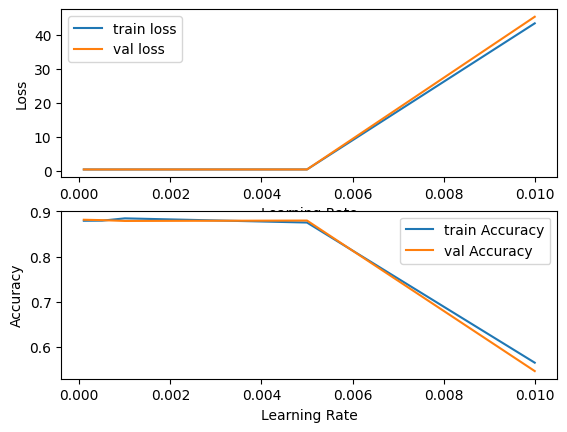

 images processed: 1451921 and epoch 20
 images processed: 1451345 and epoch 20
 images processed: 1452675 and epoch 20
 images processed: 1451051 and epoch 20
 images processed: 1123461 and epoch 16

In [ ]:
for codedist in [5, 7, 9]:
  sweeplr(codedist)

In [15]:
def trainfinalmodel(code_distance, numoutchannels=24, filter_size=7, directory="modelparams1" ):
    os.makedirs(directory, exist_ok=True)
    fname1 = os.path.join(directory, "conv_model_codedist{}_{}_{}.model".format(code_distance, \
                                                                                numoutchannels, filter_size))
    fname2 = os.path.join(directory, "conv_model_codedist{}_{}_{}.csv".format(code_distance, \
                                                                                numoutchannels, filter_size))
    fname3 = os.path.join(directory, "conv_model_codedist{}_{}_{}.png".format(code_distance, \
                                                                                numoutchannels, filter_size))
    probs = [0.1]
    training_data_size = len(probs)*20000
    test_data_size = len(probs)*1000
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 200
    ckt = createcircuit(code_distance, 2, round_data_noise=probs[0])
    testset = CustomTensorDataset(dataset=sampledata(ckt, code_distance, 10000, 2))
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

    criterion = nn.BCELoss()
    net = Netconv(code_distance, numoutchannels, filter_size)
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    [y1, y2, y3, y4] = trainmodel(net, code_distance, [0.12], \
                   training_data_size, testloader, \
                   optimizer, criterion, epochs, device, batchsize=48, valinterval=5)
    torch.save(net.state_dict(), fname1 )
    fout1 = open(fname2, 'w')
    fout1.write("INDEX,TRAIN-LOSS,VAL-LOSS,TRAIN-ACCURACY,VAL-ACCURACY\n")
    for i,v, in enumerate(y1):
        fout1.write("{},{},{},{}\n".format(y1[i],y3[i],y2[i],y4[i]))
    fout1.close()
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].plot(y1, label='train loss')
    axes[0].plot(y3, label='val loss')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    #axes[0].set_ylim(0.5,1)
    axes[0].legend()
    axes[1].plot( y2, label='train Accuracy')
    axes[1].plot( y4, label='val Accuracy')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    #axes[1].set_ylim(0.5,1)
    axes[1].legend()
    plt.savefig(fname3)
    plt.show()

In [16]:
def loadmodel(modelpath, code_dist, numchannels, filtersize, device):
    model = Netconv(code_dist, numchannels, filtersize)
    model.load_state_dict(torch.load(modelpath))
    model.to(device)
    return model

In [33]:
def plot_logical_error_vs_physical_error(filename, directory="Performance"):
    os.makedirs(directory, exist_ok=True)
    fname = os.path.join(directory, filename)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    path_root = "models"
    logical_error_hash = {}
    pm_error = {}
    #probs = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.12]
    probs = np.linspace(0.0001, 0.1, 30)
    for code_dist in [5, 7, 9]:
        logical_error_hash[code_dist] = []
        pm_error[code_dist] = []
        for p in probs:
            print("\r Working probabibility: {} and code distance {}".format(p, code_dist), end='')
            logical_error_hash
            ckt = createcircuit(code_dist, 4, measure_flip_prob=p,  clifford_noise=p, reset_flip_prob=p, round_data_noise=p)
            #ckt = createcircuit(code_dist, 4, clifford_noise=p, reset_flip_prob=p, round_data_noise=p)
            #ckt = createcircuit(code_dist, 4, reset_flip_prob=p, round_data_noise=p)
            #ckt = createcircuit(code_dist, 4, round_data_noise=p)
            X,y,pm_preds = sampledataforinference(ckt, code_dist, 3200, 4)
            testset = CustomTensorDataset(dataset=[X,y])
            testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
            criterion = nn.BCELoss()
            codei_dist = code_dist
            if code_dist != 5:
                codei_dist = 5
            modepath = os.path.join(path_root, "conv_model_codedist{}_24_7.model".format(codei_dist))
            model = loadmodel(modepath, codei_dist, 24, 7, device)
            model.eval()
            val_inacc = 0.0
            pm_inacc = 0.0
            ind = 0
            y = np.squeeze(y)
            for i in range(y.shape[0]):
                if (y[i] != pm_preds[i]):
                    pm_inacc += 1
            pm_error[code_dist].append(pm_inacc/(y.shape[0]))
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    val_inacc += ((outputs > 0.5) != labels).sum().item()
            logical_error_hash[code_dist].append(val_inacc/(1.0*3200))
    print("")
    fig, axes = plt.subplots(nrows=1, ncols=1)
    fname1 = open(os.path.join(directory, "{}.csv".format(filename)),'w')
    fname1.write("PROBS,CODEDIST-5,CODEDIST-7,CODEDIST-9\n")
    for i in range(len(probs)):
        fname1.write("{},{},{},{}\n".format(probs[i],logical_error_hash[5][i], \
                                            logical_error_hash[7][i], logical_error_hash[9][i]))
    fname1.close()
    for code_dist in [5, 7, 9]:
        axes.loglog(probs, logical_error_hash[code_dist], label="Code distance {}".format(code_dist))
        #axes.loglog(probs, pm_error[code_dist], label="pm {}".format(code_dist))
    #axes.plot(probs, pm_error, label="pm")
    axes.set_xlabel("Physical Error Rate")
    axes.set_ylabel("Logical Error Rate")
    axes.legend()
    plt.savefig(fname)
    plt.show()

 Working probabibility: 0.1 and code distance 9


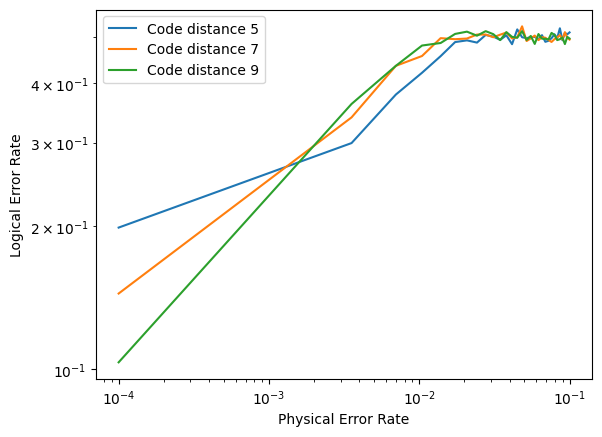

In [34]:
#plot_logical_error_vs_physical_error("all_error_processes")
plot_logical_error_vs_physical_error("all_three_replaced_by_5")